<a href="https://colab.research.google.com/github/bigyunicorn/fastai22/blob/main/lesson05/Linear_model_and_neural_net_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have been following Jeremy's notebook using the github copilot on Github codespace. 
I have been found this method is quite effective so I am sharing my process here. 
___
#### Tips for taking the FastAI course.
- Watch a lecture e2e one time.
- Copy each given Kaggle notebook to your Kaggle, and follow through each code on your own.
- Think about main steps from the notebook and write those down in a separate noteplace.  (I usually use these main steps as the title of each section).
- Expand each of the main steps and break it down smaller steps so you can easily ask the copilot to write the code.
- Reproduce the results on Github codespace with assistance from Copilot. 
- Publish your notebook to github.


# A few key points from the lesson 05


* To me, the purpose of the chapter 5 is to show how to create a deep learning model from the scratch by setting up a linear model and a neural net first and then expanding them to create a deep learning model.
* We are simply using plain python and pytroch to create the model so that we can understand the pains of not using the framework such as FastAI.
 - In the chapter 4, we used the hugging face library to train the existing model. For the previous chapters, we used fastai. But here, we are only relying on python and pytorch (To be 100% correct, we use the fast ai library once to create a validation set. We learned about how to create a meaningful validation set from the scratch in [Iterate like a grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/#Creating-a-validation-set)).
- Spoiler: It is painful as we need to figure out how to do initialization, normalization and learning rate from the scratch. The cost of this pain is that it is making hard for people to experiment more.
- We will go through the same procdess but using the framework in our [second notebook](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework)

# Important Context
* The given problem we are going to use:
  - We are tasked to predict which passengers survived the Titanic shipwreck.
  - This is a very beginner frinedly kaggle competition. [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview/evaluation).
  - You can find the data here: https://www.kaggle.com/competitions/titanic/data
  - The metric(evaluation) we are going to use is accuracy. You can find the information in the [evaluation](https://www.kaggle.com/competitions/titanic/overview/evaluation) tab.
* This is the same data we used for the [Lesson 03](https://course.fast.ai/Lessons/lesson3.html) where we created a neural net from the scratch in the excel.
  - You can find my notes for this lesson here: https://github.com/bigyunicorn/fastai22/blob/main/lesson03/titanic-data-visualization.ipynb



### Miscellanous side notes: Google Colab vs Github Codespaces Pros & Cons
- Google Colab pros: 
  - Specialized for juptyer notebook-like experiments. 
  - Free/Paid Gpu Support is there. 

- Google Colab Cons:
  - You always need to give a permission to connect with your google drive.
  - Files are not saved. 
  - No coding copilot like support (Codey is coming soon)

- Github CodeSpaces Pros: 
  - you can use copilot. 
  - Files are saved. 
  - Easy usage with github using the git CLI.

- Github CodeSpaces cons:
  - You need to specify some setups (but noe: you can use Jupyter notebook template)
  - No GPU support yet.


## Set up:
- Make sure your kernel is running on GPU.
- Get Kaggle API key from Kaggle (it will download kaggle.json).
- Copy the key value and put it in the right below cell.
- More details: https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners#Introduction

In [2]:
creds = '{"username":"<your kaggle user name>","key":"<your kaggle api key>"}'

In [4]:
# only need to run once.
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Okay, now ready to use Kaggle API to download the dataset!

Let's first install the kaggle package.

## Step 1: Get the dataset from Kaggle

In [5]:
# install the kaggle package so we can use its API.
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [6]:
# The below is useful code to fetch dataset we are interested in from Kaggle.
# you can use the same code if you are on kaggle.
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic') #kaggle dataset data tab has this name at the end.
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path)) # this is the kagglge python library API
        zipfile.ZipFile(f'{path}.zip').extractall(path) # extract all files from zip

Note: the below is a bsh command to download the data. Github copilot might recommend this line.

`!kaggle competitions download -c titanic`

## Step 2: Check the dataset structure and explore the data.

The key ideas from this step are:
- Open the csv file using pandas
- Understand the data (check categorical, continuous data columns using pandas' describe method)
- Clean up the data (filling out the missing fields with the most commonly appeared words, normalize the data, convert the categorical data to the format that makes senese using pandas' get_dummies, etc)
- Create tensors for independent & dependent variables*.

In [7]:
# Now, let's see the file structure of Kaggle downloaded dataset
!ls {path}

gender_submission.csv  test.csv  train.csv


Once I confirmed that the files are in csv, I am going to use pandas, as it is a library that has many useful functions for handling csv files. In this codespace, pandas library is in requirements.txt, so I can skip `pip install pandas` and directly import the library as pd.(If you use Google Colab, it already installed pandas)

In [8]:
import pandas as pd

In [9]:
# read the train.csv using pandas
df = pd.read_csv(path/'train.csv')

In [10]:
# print out dataframe (df)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Let's explore the data a bit more to feel the data intuitively. 

In [11]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
df.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What are some interesting facts about the data? Seems like.. `Fare` has a wide range. Also `Age` has also a wide range of distribution. Maybe I might want to noramlize the data in those columns. 

First, let's check whether they are any missing variables. 

In [13]:
# check any missing values.
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Seem like `Age` and `Cabin` have the most number of missing values. I probably want to fill those missing fields with the most common values. Let's figure out the most common values.

Jeremy's tips:
- We'll need to replace the missing values with something. 
- It doesn't generally matter too much what we choose. We'll use the most common value (the "mode"). 
- We can use the mode function for that. One wrinkle is that it returns more than one row in the case of ties, so we just grab the first row with iloc[0]:

In [14]:
# Let's see the common value of each column using padnas's mode function.
df.mode()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3.0,"Abbing, Mr. Anthony",male,24.0,0.0,0.0,1601,8.05,B96 B98,S
1,2,NaN,NaN,"Abbott, Mr. Rossmore Edward",NaN,NaN,NaN,NaN,347082,NaN,C23 C25 C27,NaN
2,3,NaN,NaN,"Abbott, Mrs. Stanton (Rosa Hunt)",NaN,NaN,NaN,NaN,CA. 2343,NaN,G6,NaN
3,4,NaN,NaN,"Abelson, Mr. Samuel",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,"Abelson, Mrs. Samuel (Hannah Wizosky)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,NaN,NaN,"de Mulder, Mr. Theodore",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,888,NaN,NaN,"de Pelsmaeker, Mr. Alfons",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,889,NaN,NaN,"del Carlo, Mr. Sebastiano",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,890,NaN,NaN,"van Billiard, Mr. Austin Blyler",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


oh when I do mode, I get a table. I think it is because the values for `Name` are all unique. Let's try only numerical values. 

In [15]:
# Get the most common value of columns that are numeric.
df.mode(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0.0,3.0,24.0,0.0,0.0,8.05
1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
886,887,NaN,NaN,NaN,NaN,NaN,NaN
887,888,NaN,NaN,NaN,NaN,NaN,NaN
888,889,NaN,NaN,NaN,NaN,NaN,NaN
889,890,NaN,NaN,NaN,NaN,NaN,NaN


Huh, still not returning one value. It seems like because there are many competing values. Let's get the first element if there are multiple elements that appear most commonly.

In [16]:
df.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [17]:
# substitue missing fields with the most common value.
df = df.fillna(df.mode().iloc[0])

<Axes: >

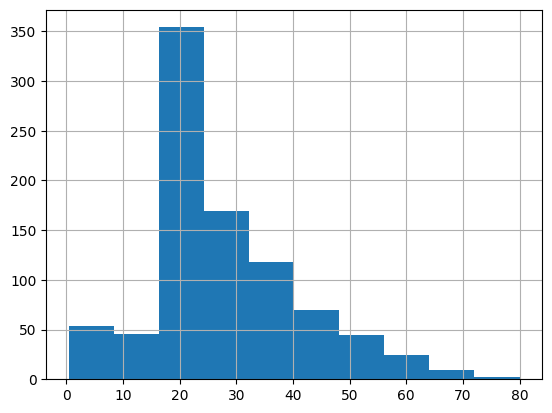

In [18]:
# Let's see the distribution of age.
df.Age.hist()

Not too bad, but still I think it will be better to do some normalization.

In [19]:
# Divde the age by its max value to normalize it.
# Later note: we will skip this part as we will need to do this normliazation for outher data as well..
# df.Age = df.Age / df.Age.max()

<Axes: >

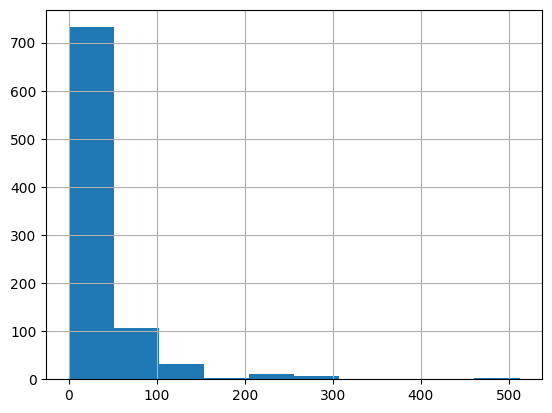

In [20]:
# Let's see the distribution of fare.
df.Fare.hist()

Oo yeah, let's definitely normalize this data as it can cause problems for our model, because once that column is multiplied by a coefficient later, the few rows with really big values will dominate the result.

Let's take the log of the data.

In [21]:
# Take the log of fare to make it more normal.
import numpy as np
df.Fare = np.log(df.Fare+1) # the copilot recommended 1e-3, but it was still a bit not enough to make it normal.

In [22]:
df # print out the dataframe to see how the data looks like. 
# Note `Fare` is still not in 0-1 range yet even after taking log.Age is now really big.
# This tells us that we might want to noramlize the data later. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,2.110213,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.280593,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.188856,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.990834,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.202765,B96 B98,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,2.639057,B96 B98,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,3.433987,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,3.196630,B96 B98,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,3.433987,C148,C


Let's quickly check the features of numerical and categorical data.

In [23]:
df.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,2.962246
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,0.969048
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,2.187218
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,2.737881
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,3.465736
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,6.240917


In [24]:
# Pclass seems to have only three values. Let's check.
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [25]:
# describe cateogorical columns
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Okay now.. we want to use Sex, Embarked information, but they are not numeric. We need to change them to be numerical because
we can't multiply strings like male or S by coefficients. 
How can we do that? 

We can create dummy variables. 
- A dummy variable is a column that contains a 1 where a particular column contains a particular value, or a 0 otherwise. 
- Pandas can create these automatically using get_dummies, which also remove the original columns. 

One constraint is: if a column has so many unique values, using dummy variables isn't too meaningful. So we won't use dummy variables columns suc as `Name`, `Ticket`, `cabin`. So we will use this for `Sex` and `Embarked`. 

The other interesting fact is that we can use this for the numerical column whose value is not necessarily meaningful to multiply by. In our case, that's `Pclass`. So we are going to aslo create dummy variables for `Pclass` as well. 

In [26]:
# create dummy variables for `Sex`, `Embarked`, `Pclass` columns using pandas get_dummies function.
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [27]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Okay now we have the data ready, let's think about three important things about the data. 
- inputs (independent variables)
- predictions  (≠ labels).
- labels  (dependent variable(s))

A: Our inputs are going to be: total 12.
- (1) Age
- (2) SibSp
- (3) Parch
- (4) Fare
- (5) Sex_female
- (6) Sex_male
- (7) Pclass_1
- (8) Pclass_2
- (9) Pclass_3
- (10) Embarked_C
- (11) Embarked_Q
- (12) Embarked_S

B: Our predictions are going to be the probabiliy of the survival. 

C: The labels is in the `Survived` column.

The independent & dependent variables need to be tensors so that we can use them to create our model. Let's try to create that. 

In [28]:
independent_variables_columns = ["Age", "SibSp", "Parch", "Fare"] + added_cols

# create a tensor using the independent variables columns.
import torch
t_indep = torch.tensor(df[independent_variables_columns].values, dtype=torch.float32)

# create a tensor suing the dependent variable column.
t_dep = torch.tensor(df.Survived.values, dtype=torch.float32)

In [29]:
# check the shape of the independent tensor & dependent tensor.
t_indep.shape, t_dep.shape

(torch.Size([891, 12]), torch.Size([891]))

In [30]:
t_indep[:5]

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000]])

In [31]:
# This is a side note to see how to use max function of pytorch across all columns. 
# For my example, I only used this max function to noramlize age based on the lecture from Lesson 03. 
# But technically we can use it to divide each column by its max value. 

# Get the max of each column of t_indep.
vals,indices = t_indep.max(dim=0) # vals is the max value of each column, indices is the index of the max value of each column.
vals, vals.shape, indices # vals, indices are vectors. 


(tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000]),
 torch.Size([12]),
 tensor([630, 159, 678, 258,   0,   1,   1,   9,   0,   1,   5,   0]))

In [32]:
# Divide each column of t_indep by its max value.
t_indep = t_indep / vals
t_indep

tensor([[0.2750, 0.1250, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.3000, 0.1250, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000]])

What is cool about the above line? Because it talks about numpy's broadcasting feature!
If you think about it, t_indep is matrix and vals is a vector.

So basically, we are dividing a matrix by a vector. It is possible because we are using the braodcasting feature (many programing langues have this feature).

What is this broadcasting feature about? How does it work? 
From Jeremy's explanation - 
- This feature allows our machine thinks that there is a separate copy of the vector for every row of the matrix, and divides each row of the matrix by the vector. 
- In practice, this does not create any copies, and does this operation in a highly otpimized way, taking full advantage of modern CPUs or GPUs. 
- Broadcasting is one of the most important techniques for making your code concise, maintainable, and fast, so it's well worth studying and practicing.

Another thing to think about is how we want to create a training set and a validation set. Quickly skimming through data in the training.csv and the test.csv, I think the easiest choice of creating a validation set (random splitter) is okay. But let's see whether we will stick to this.

## Setting up a linear model

In this section, we are going to create a linear model from the scratch. This means we are creating a model with one layer (output layer). 

The below image shows what the linear model looks like: 
[TBD: put the screenshot of the image]

The high level process of a setting up a linear model is like below. Please note, this process does not include the training part (as such we don't actually work on creating training & validation set and coming up with metrics yet). We will hand that part separateyl.
- (1) Initialize Coefficients: Create the number of coefficients that correspond to the number of inputs & initialize with random values. 
- (2) Calculate a prediction per row: Multiply each element of the inputs with the each corresponding element of coefficients and add them up.
- (3) Calculate the total loss using the prediction and the loss of each row and summing the results up.
- (4) Take the gradient descent of the loss function
- (5) Use the grad values of the coefficients, update the coefficients. 

In [33]:
# create coeff tensor with random values. The size of coeff tensor should be the same as the number of independent variables. 
# we want the random values to be between -0.5 and 0.5 based on Jeremy's recommendation; 
# He got this number after multiple experiments.To focus on our essence of the practice of building a linear model, we will take his recommendation.

t_coeff = torch.rand(len(independent_variables_columns)) - 0.5
t_coeff, t_coeff.shape


(tensor([ 0.1681, -0.2407,  0.4483,  0.1766, -0.1443,  0.3300,  0.2960, -0.3719,
         -0.0702,  0.1998, -0.2471,  0.0225]),
 torch.Size([12]))

### Notes: A few things that I initially did and were incorrect. 

(1) Initally, I kept getting values that were outside of [-0.5, 0.5] as I used torch.randn to initizlie random values. 
```
t_coeff = torch.randn(len(independent_variables_columns)) - 0.5
t_coeff, t_coeff.shape
```
- This is indeed sneaky. I was not aware of this. The code itself was generated by Copilot and without having much knowedge in pytorch, this was hard to catch. 

- This made the values for the predictions outside of 0,1 range. 
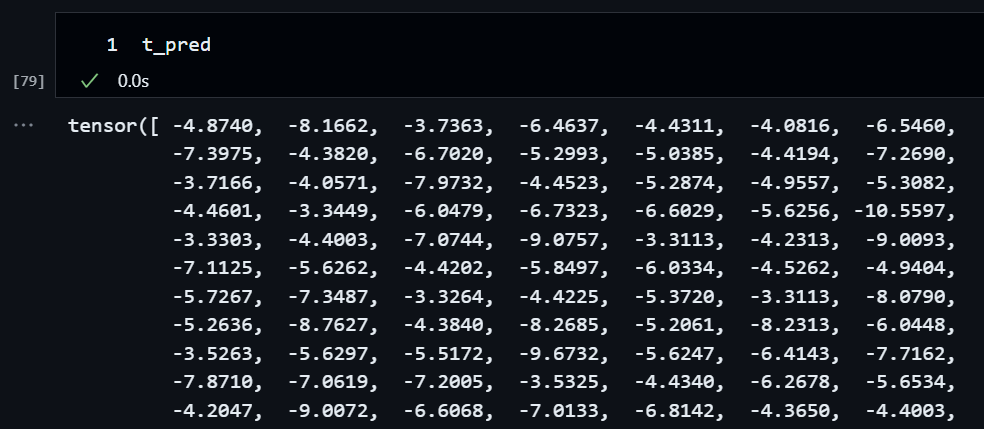

(2) I set the tensor's requires_grad_ attribute while I was initializing them. 
```
t_coeff = torch.randn(len(independent_variables_columns), requires_grad_) - 0.5
t_coeff, t_coeff.shape
```
- The problem with this choice was that when I tried to print grad of coeffs, I was getting the following error.
".grad attribute of a non-leaf tensor being accessed."
- And the solution here: https://discuss.pytorch.org/t/grad-attribute-of-a-non-leaf-tensor-being-accessed/82313/2

In [34]:
# multiply the independent tensor with coeff tensor.
(t_indep*t_coeff)[:10]

tensor([[ 0.0462, -0.0301,  0.0000,  0.0597, -0.1443,  0.0000,  0.0000, -0.0000,
         -0.0702,  0.0000, -0.0000,  0.0225],
        [ 0.0798, -0.0301,  0.0000,  0.1212, -0.0000,  0.3300,  0.2960, -0.0000,
         -0.0000,  0.1998, -0.0000,  0.0000],
        [ 0.0546, -0.0000,  0.0000,  0.0620, -0.0000,  0.3300,  0.0000, -0.0000,
         -0.0702,  0.0000, -0.0000,  0.0225],
        [ 0.0735, -0.0301,  0.0000,  0.1130, -0.0000,  0.3300,  0.2960, -0.0000,
         -0.0000,  0.0000, -0.0000,  0.0225],
        [ 0.0735, -0.0000,  0.0000,  0.0623, -0.1443,  0.0000,  0.0000, -0.0000,
         -0.0702,  0.0000, -0.0000,  0.0225],
        [ 0.0504, -0.0000,  0.0000,  0.0636, -0.1443,  0.0000,  0.0000, -0.0000,
         -0.0702,  0.0000, -0.2471,  0.0000],
        [ 0.1135, -0.0000,  0.0000,  0.1123, -0.1443,  0.0000,  0.2960, -0.0000,
         -0.0000,  0.0000, -0.0000,  0.0225],
        [ 0.0042, -0.0903,  0.0747,  0.0876, -0.1443,  0.0000,  0.0000, -0.0000,
         -0.0702,  0.0000, -0.

In [35]:
# calculate the prediction of each row by summing up the values of each row.
t_pred = (t_indep*t_coeff).sum(axis=1) #I can use dim=1 as well.
t_pred[:10]

tensor([-0.1161,  0.9967,  0.3989,  0.8050, -0.0561, -0.3476,  0.4000, -0.1157,
         0.5591,  0.2545])

Okay now we calculated the prediction of each row with randomly initialized coefficients as a starting point. 

To create a more meaningful model, we need to update these coefficients. To update the coefficients, we need to do gradient descent of the loss function. 

Let's define our loss function, which returns the total loss of the dataset. The simpliest way is to caculate the error between the prediction and the label per row and summing the loss up. 

In [36]:
# calculate loss by taking the absolute value of the difference between the preidictions and the dependents and take the average.
t_loss = (t_pred - t_dep).abs().mean()
t_loss, t_loss.shape # scalar value.

(tensor(0.3832), torch.Size([]))

So now we have a way to calculate preidctions and the los, let's create functions to get each of them. 

In [37]:
# define a function that takes in coefficients, independent variables, and return the predictions.
def calc_preds(t_indep, t_coeff):
    return (t_indep * t_coeff).sum(axis =1)

# define a function that takes in predictions and dependents, and return the loss.
def calc_loss(t_pred, t_dep):
    return (t_pred - t_dep).abs().mean()

# update calc_loss function to use calc_preds function to calculate the preidctions.
def calc_loss(t_indep, t_dep, t_coeff):
    return (calc_preds(t_indep, t_coeff) - t_dep).abs().mean()

Okay, now let's do a single epoch (as we are going to use the entire data) of graident descent.

Major 5 steps invovled here - 
- (1) Call `requires_grad_()` on our coefficients. 
- (2) Calculate the loss.
- (3) Calculate the gradient.
- (4) Update the parameters using the gradient and the learning rate. 
- (5) Set the `.grad` values to be zero as we want to calculate `.grad` independently from the previous run.

In [38]:
# track gradient of coeff tensor.
t_coeff.requires_grad_()

tensor([ 0.1681, -0.2407,  0.4483,  0.1766, -0.1443,  0.3300,  0.2960, -0.3719,
        -0.0702,  0.1998, -0.2471,  0.0225], requires_grad=True)

In [39]:
# Calculate the loss 
t_loss = calc_loss(t_indep, t_dep, t_coeff)
t_loss

tensor(0.3832, grad_fn=<MeanBackward0>)

In [40]:
# calculate the gradient of the loss.
t_loss.backward()

In [41]:
# Update the parameters using the gradient and the learning rate
with torch.no_grad():
    t_coeff -= t_coeff.grad * 1e-5
    # set the gradient to zero so that it doesn't accumulate.
    t_coeff.grad.zero_()

In [42]:
# We just completed one gradient step. Let's make it a function.
def step(t_indep, t_dep, t_coeff, lr):
    t_coeff.requires_grad_()
    t_loss = calc_loss(t_indep, t_dep, t_coeff)
    t_loss.backward()
    with torch.no_grad():
        t_coeff -= t_coeff.grad * 1e-5
        t_coeff.grad.zero_()

In [43]:
# update the step function to use tensor substract function.
def one_epoch(t_indep, t_dep, t_coeff, lr):
    t_loss = calc_loss(t_indep, t_dep, t_coeff)
    t_loss.backward()
    with torch.no_grad():
        t_coeff.sub_(t_coeff.grad * lr) # Updating coefficients; Note that a.sub_(b) subtracts b from a in-place In PyTorch, any method that ends in _ changes its object in-place
        t_coeff.grad.zero_() # Similarly, a.zero_() sets all elements of a tensor to zero.
    print(f"{t_loss:.3f}", end="; ")

Okay so we just did the gradient step for one epoch (the entire training dataset). 
Let's now train this linear model. To do training, we need a training data set and a validation dataset. 

## Train a linear model
As I briefly mentioned above, we are going to create a training dataset and a validation dataset because we do need the validation set for calculating our metrics. 

We are going to use FastAI randomsplitter. 

- To do training, we need to remember two important components.
    - Having training and validation sets.
        - Training set is important to do everything that we did for one single epcoh. We will do a few more epochs.
            - At each epoch, we want to know how well the model is doing. This is going to be judged by a metric.
        - Validation set is important to calculate the metric.
            - Validation independent variables are going to be fed to the model that now has fixed weights, and using the validation dependent variables (labels), we will calculate the performance.
            - For each epoch (which is temporarily done with weight update), we can calculate the metric using the predictions & the validation depdendent variables.
    - Metrics.
        - For Titanic data set, it is going to be measured by accuracy metrics.
        - As it is a kaggle competition, it is given. But otherwise, we need to think hard about it.
    - For setting up the model, knowing my independent variables, predictions and dependent variables is enough.
    - But for training, we want to iterate through a few times with the metric per epoch.


In [44]:
# Create a training dataset and a validation dataset using the fastai randomsplitter. 

from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df) # seed is set to 42 to make sure we get the same result every time we run this code.

#trn_split, val_split: index of training set and validation set. Both are type L.
type(trn_split), type(val_split)

# print out the length of each set
len(trn_split), len(val_split)

(713, 178)

In [45]:
# Split the independent tensor and dependent tensor into training and validation set.
t_indep_trn = t_indep[trn_split]
t_dep_trn = t_dep[trn_split]
t_indep_val = t_indep[val_split]
t_dep_val = t_dep[val_split]

# print out all the shapes to make sure we split the data correctly.
t_indep_trn.shape, t_dep_trn.shape, t_indep_val.shape, t_dep_val.shape

(torch.Size([713, 12]),
 torch.Size([713]),
 torch.Size([178, 12]),
 torch.Size([178]))

As we want to train our linear model, we want to do the gradient descent step a few times so that we can update our coefficients to make them more meaningful. 

Main key steps to train a model. 
- (0) Randomly initialize coefficients and assign `.grad` attribute. 
- (1) For # of epochs you chose, take the gradient descent step. 
  - In each gradient descent step:
    - Calculate predictions with the inputs and the coefficients. 
    - calculate the loss using the predictions and the dependent variables.  
    - Take the gradient descent step on the loss. 
    - Update the parameters using the learning rate and the gradient descent. 
    - zero 'grad' of coefficients. 

In [46]:
# Create a function to train model that accepts the number of epochs, learning rate, and the independent and dependent tensors.
def train_model(epochs, lr, t_indep, t_dep):
    # initialize the coeff tensor with random values.
    t_coeff = torch.rand(len(independent_variables_columns)) - 0.5
    # require gradient tracking.
    t_coeff.requires_grad_()
    # loop through the number of epochs.
    for i in range(epochs):
        # calculate the predictions and the loss.
        t_pred = calc_preds(t_indep, t_coeff)
        t_loss = calc_loss(t_pred, t_dep)
        # calculate the gradient and update the coeff tensor.
        t_loss.backward()
        with torch.no_grad():
            t_coeff -= t_coeff.grad * lr
            t_coeff.grad.zero_()

In [47]:
# update train_model to use one_epoch function in the loop.
def train_model(epochs, lr, independent_variables, dependent_variables):
    torch.manual_seed(442)
    # initialize the coeff tensor with random values.
    coefficients = torch.rand(len(independent_variables_columns)) - 0.5
    # require gradient tracking.
    coefficients.requires_grad_()
    # loop through the number of epochs.
    for i in range(epochs):
        # calculate the predictions and the loss.
        one_epoch(independent_variables, dependent_variables, coefficients, lr)
    # return the coeff tensor.
    return t_coeff

In [48]:
# call train_modl with training dataset.
coeffs = train_model(50, 0.2, t_indep_trn, t_dep_trn)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 0.292; 0.284; 0.290; 0.288; 0.295; 0.281; 0.285; 0.282; 0.285; 0.279; 0.278; 0.283; 0.294; 0.279; 0.282; 0.283; 0.305; 0.279; 0.287; 0.277; 0.293; 0.280; 0.307; 0.272; 0.288; 0.271; 0.294; 0.282; 0.311; 0.269; 0.289; 0.269; 

In [49]:
def show_coeffs(): return dict(zip(independent_variables_columns, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(0.1681),
 'SibSp': tensor(-0.2407),
 'Parch': tensor(0.4483),
 'Fare': tensor(0.1766),
 'Sex_male': tensor(-0.1443),
 'Sex_female': tensor(0.3300),
 'Pclass_1': tensor(0.2960),
 'Pclass_2': tensor(-0.3719),
 'Pclass_3': tensor(-0.0702),
 'Embarked_C': tensor(0.1998),
 'Embarked_Q': tensor(-0.2471),
 'Embarked_S': tensor(0.0226)}

Okay so now we finished the training. But to really understand that our model is improving per epoch, we need to use the metric. 

Our metric is accuracy as this Kaggle competition requires it. Let's calculate the accuracy to think about how to define the accuracy function. 

In [50]:
# calculate predictions from the validation dataset.
t_pred_val = calc_preds(t_indep_val, coeffs)
t_pred_val[:10]

tensor([-0.1652, -0.3498,  0.0953, -0.3338, -0.3664, -0.3648,  0.6182,  0.1142,
        -0.0814,  0.6438])

As you cans see, t_pred is a tensor of values have some negative values and also some values that are greater than 1.

When we are calculating the prediction, let's make sure that each pred is between 0 and 1. We will use sigmoid function to do so. But let's revisit this part after we define the accuracy function. 

In [51]:
# calculate the accuracy using t_pred_val and t_dep_val.
accuracy = ((t_pred_val > 0.5) == t_dep_val).float().mean()
accuracy

tensor(0.7079)

In [52]:
# define calculating accuracy function using calc_preds function.
def calc_accuracy(t_indep, t_dep, t_coeff):
    t_pred = calc_preds(t_indep, t_coeff)
    return ((t_pred > 0.5) == t_dep).float().mean()

Let's update our train_model function to apply sigmoid on our prediction.

In [53]:
# update calc_pred function to apply sigmoid function on our predictions.
def calc_preds(t_indep, t_coeff):
    return torch.sigmoid((t_indep * t_coeff).sum(axis =1))

In [54]:
# train model with trianing dataset.
coeffs = train_model(50, 0.2, t_indep_trn, t_dep_trn)

0.510; 0.506; 0.502; 0.497; 0.493; 0.489; 0.485; 0.481; 0.477; 0.472; 0.468; 0.464; 0.460; 0.457; 0.453; 0.449; 0.446; 0.442; 0.439; 0.435; 0.432; 0.429; 0.426; 0.423; 0.420; 0.417; 0.414; 0.411; 0.409; 0.406; 0.404; 0.401; 0.399; 0.397; 0.394; 0.392; 0.390; 0.388; 0.386; 0.384; 0.382; 0.380; 0.379; 0.377; 0.375; 0.374; 0.372; 0.370; 0.369; 0.367; 

In [55]:
# using calc_accuracy, calculate the accuracy of the model. 
acc = calc_accuracy(t_indep_val, t_dep_val, coeffs)
acc

tensor(0.7528)

In [56]:
show_coeffs()

{'Age': tensor(0.1681),
 'SibSp': tensor(-0.2407),
 'Parch': tensor(0.4483),
 'Fare': tensor(0.1766),
 'Sex_male': tensor(-0.1443),
 'Sex_female': tensor(0.3300),
 'Pclass_1': tensor(0.2960),
 'Pclass_2': tensor(-0.3719),
 'Pclass_3': tensor(-0.0702),
 'Embarked_C': tensor(0.1998),
 'Embarked_Q': tensor(-0.2471),
 'Embarked_S': tensor(0.0226)}

Hmm.. the accuracy ain't that good. Also the result does not quite make sense. As we expect the female & Pclass_1 have higher accuracy, but they don't.  I think there are some set ups that I didn't do correctly.
But I got the point of every single line and was able to figure out my logical loops while I was trying to set this linear model by myself. So I am going to move on to the next section, which is using the linear model for the test dataset. 

# Submit the result to Kaggle
This is reading test.csv file which is the test data set.
We will mainly do three things.
(1) Pre-process the data exactl the same way we did for the training dataset.
(2) Put the indepent variables of the test data to our linear model to get prediction.
(3) And if the prediction is >0.5, mark it as survived. 

In [57]:
# read test.csv file
df_test = pd.read_csv(path/'test.csv')

# print out the test dataframe.
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [58]:
# check the missing values.
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [59]:
# `Fare` column has a missing value. Let's fill it with 0 to avoid problems.
df_test['Fare'] = df_test.Fare.fillna(0)

In [60]:
# substitue missing fields with the most common value.
mode = df_test.mode().iloc[0] #please check the last section of the notebook. Heads-up: Jeremy still uses the same mode with the training dataset. 
df_test.fillna(mode, inplace=True)

# pre-process the data
df_test['LogFare'] = np.log(df_test['Fare']+1)
df_test = pd.get_dummies(df_test, columns=["Sex","Pclass","Embarked"])

# Create independent variables tensor for the test dataset. 
tst_indep = torch.tensor(df_test[independent_variables_columns].values, dtype=torch.float)
vals,indices =tst_indep.max(dim=0)
tst_indep = tst_indep / vals

In [61]:
tst_indep[:10]

tensor([[0.4539, 0.0000, 0.0000, 0.0153, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 0.0000],
        [0.6184, 0.1250, 0.0000, 0.0137, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000],
        [0.8158, 0.0000, 0.0000, 0.0189, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000],
        [0.3553, 0.0000, 0.0000, 0.0169, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000],
        [0.2895, 0.1250, 0.1111, 0.0240, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000],
        [0.1842, 0.0000, 0.0000, 0.0180, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000],
        [0.3947, 0.0000, 0.0000, 0.0149, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 0.0000],
        [0.3421, 0.1250, 0.1111, 0.0566, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 1.0000],
        [0.2368, 0.0000, 0.0000, 0.0141, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,

In [62]:
# calculate the predictions using the test dataset.
tst_preds = calc_preds(tst_indep, coeffs)

tst_preds[:10]

tensor([0.4055, 0.5887, 0.3491, 0.4677, 0.5878, 0.4606, 0.5204, 0.3998, 0.6229,
        0.4508])

In [63]:
# tomorrow: finish chapter 5 using the chat gpt. 
# morning: finish setting up the models from the scratch; need to rethink the part, 
# we might want to redefine the function as it is and think about why that is the best. 
# afternoon: finish up the multiplication & deep learing aspect. 
# evening: try with the framework, and see what parts are really helpful. 
# Sunday morning: watch the lecture 6. (watch lecture, follow through the lecture and construct the notion page, and write down)
# Plan for the week (goals for the work, how I am going to pick it up, write down the insta post
# plan for resting for the july 4th week. Planning with Kuan. 

In [64]:
# set tst_df['Survived'] to 0 or 1 based on the predictions.
df_test['Survived'] = (tst_preds > 0.5).int()

df_test['Survived'] # the first column is the id.

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    1
Name: Survived, Length: 418, dtype: int32

In [65]:
sub_df = df_test[['PassengerId','Survived']]  
# when we select columns of the dataframe by name, we need to use double brackets.

In [66]:
sub_df.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.564593
std,120.810458,0.496404
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,1.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [67]:
# convert the dataframe to csv file.
sub_df.to_csv('submission.csv', index=False)

In [68]:
# print out the first few rows of the file.
!head submission.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


# Using matrix product
So far we defined the following functions to train a linear model. 



In [69]:
# define a function that takes in coefficients, independent variables, and return the predictions with the sigmoid activation function.
def calc_preds(t_indep, t_coeff):
    return torch.sigmoid((t_indep * t_coeff).sum(axis =1))

# update calc_loss function to use calc_preds function to calculate the preidctions.
def calc_loss(t_indep, t_dep, t_coeff):
    return (calc_preds(t_indep, t_coeff) - t_dep).abs().mean()

# update the step function to use tensor substract function.
def one_epoch(t_indep, t_dep, t_coeff, lr):
    t_loss = calc_loss(t_indep, t_dep, t_coeff)
    t_loss.backward()
    with torch.no_grad():
        t_coeff.sub_(t_coeff.grad * lr) # Updating coefficients; Note that a.sub_(b) subtracts b from a in-place In PyTorch, any method that ends in _ changes its object in-place
        t_coeff.grad.zero_() # Similarly, a.zero_() sets all elements of a tensor to zero.
    print(f"{t_loss:.3f}", end="; ")

# update train_model to use one_epoch function in the loop.
def train_model(epochs, lr, independent_variables, dependent_variables):
    torch.manual_seed(442)
    # initialize the coeff tensor with random values.
    coefficients = torch.rand(len(independent_variables_columns)) - 0.5
    print("coefficients matrix shape: ", coefficients.shape) # this is a vector.
    # require gradient tracking.
    coefficients.requires_grad_()

    # loop through the number of epochs.
    for i in range(epochs):
        # calculate the predictions and the loss.
        one_epoch(independent_variables, dependent_variables, coefficients, lr)
    # return the coeff tensor.
    return t_coeff

def calc_accuracy(t_indep, t_dep, t_coeff):
    t_pred = calc_preds(t_indep, t_coeff)
    return ((t_pred > 0.5) == t_dep).float().mean()

def show_coeffs(): return dict(zip(independent_variables_columns, coeffs.requires_grad_(False)))

As you can see, Jeremy intentionally used the elementwise operation in `calc_pred`. 
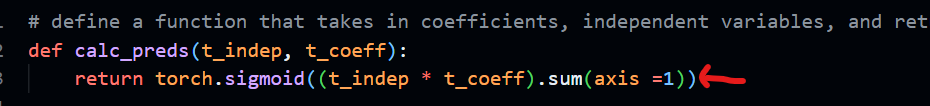

Now in this section, we are going to update this function to use the numpy's matrix multiplication. 

In [70]:
# first let's call the existing calc_preds with the training dataset.
original_preds = calc_preds(t_indep_trn, coeffs)
original_preds[:10], print("original preds shape: ", original_preds.shape) # this is a vector.

original preds shape:  torch.Size([713])


(tensor([0.5041, 0.4219, 0.4822, 0.4803, 0.5892, 0.5540, 0.7301, 0.4822, 0.4822,
         0.6077]),
 None)

In [71]:
# update calc_preds to use numpy matrix multiplication.
def calc_preds(t_indep, t_coeff):
    return torch.sigmoid(t_indep @ t_coeff)

In [72]:
# call calc_preds with the training dataset.
new_preds = calc_preds(t_indep_trn, coeffs)
new_preds[:10], print("new preds shape: ", new_preds.shape) # this is a vector.

new preds shape:  torch.Size([713])


(tensor([0.5041, 0.4219, 0.4822, 0.4803, 0.5892, 0.5540, 0.7301, 0.4822, 0.4822,
         0.6077]),
 None)

As you can see we just proved that the matrix multiplication produces the exactly the same results. 
Okay now, then let's train the model and see what happens. 

In [73]:
# train model with trianing dataset.
print("training data independent variables tensor shape: ", t_indep_trn.shape)
print("training data dependent variables tensor shape: ", t_dep_trn.shape) # this is a vector.

coeffs = train_model(50, 0.2, t_indep_trn, t_dep_trn)

training data independent variables tensor shape:  torch.Size([713, 12])
training data dependent variables tensor shape:  torch.Size([713])
coefficients matrix shape:  torch.Size([12])
0.510; 0.506; 0.502; 0.497; 0.493; 0.489; 0.485; 0.481; 0.477; 0.472; 0.468; 0.464; 0.460; 0.457; 0.453; 0.449; 0.446; 0.442; 0.439; 0.435; 0.432; 0.429; 0.426; 0.423; 0.420; 0.417; 0.414; 0.411; 0.409; 0.406; 0.404; 0.401; 0.399; 0.397; 0.394; 0.392; 0.390; 0.388; 0.386; 0.384; 0.382; 0.380; 0.379; 0.377; 0.375; 0.374; 0.372; 0.370; 0.369; 0.367; 

In [74]:
# calc accuracy using the validation dataset.
acc = calc_accuracy(t_indep_val, t_dep_val, coeffs)
acc

tensor(0.7528)

Okay we just confirmed that the accuracy and coefficents haven't changed. But why did Jeremy have a section to update the code to use matrix multiplication?

We will see the why in the next section.

# Create a neural network
This section is the essence part of this notebook. We want to create a neural network. 
To create a neural network, a few major things to note. 

- (1) A neural network can identify non-linear relationship as it uses a non linear function. --> we will use ReLu as an activation function.
- (2) Because we can use a non-linear function, we can combine several non-linear functions, and use the results from each of the function to calculate the final output. --> introduce a hidden layer with one or more functions. 

For this experiment, let's create a neural network with one hidden layer ( so the neural net will have total 2 layers, including the out put layer part). And let's assume this hidden layer size is `n_hidden`. This `n_hidden` can be considered as # of outputs. 

The below is the visualization of this neural net. 

With this additional new layer, it means we need to introduce two coefficient matrix. 
- (1) The first layer coefficient matrix will be: [# of independent columns,  n_hidden]
- (2) The second layer coefficient matrix will be: [n_hidden, 1] as the size of the output layer is 1. 
- (3) Also, we want to add the bias in the hidden layer
With this inforamtion let's create a function that returns the two coefficient matrices and a constant. 

A few key points for the functions that need to be updated:
- initializing coefficients (we need to initialize each layer of matrix)
- calculating predictions needs to be updated to apply each hidden layer's activication function. 
- updating coefficietns (each layer needs to get updated)


In [106]:
# define init_coeffs function that takes in the number of hidden layers and return the initialized coefficients.
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(len(independent_variables_columns), n_hidden)-0.5)
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0] # for const, we want to return scalar value, not a tensor.
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [127]:
# define calc_preds function that takes in the independent variables tensor and the coefficients and return the predictions.
# use Relu as an activation function for the first layer and sigmoid for the second layer.
def calc_preds(t_indep, coeffs):
    
    layer1,layer2,const = coeffs
    # first layer
    t_pred1 = torch.relu(t_indep @ layer1)
    # second layer
    t_pred2 = torch.sigmoid(t_pred1 @ layer2 + const)
    return t_pred2


Now we need to update our code related to updating coefficients because we now have multiple (two) coefficient matricies. 

In [89]:
# define update_coeffs function.
# This is for the linear model
def update_coeffs(coeffs,lr):
    coeffs.sub_(coeffs.grad * lr) # Updating coefficients; Note that a.sub_(b) subtracts b from a in-place In PyTorch, any method that ends in _ changes its object in-place
    coeffs.grad.zero_() # Similarly, a.zero_() sets all elements of a tensor to zero.

In [90]:
# update one_epoch function to use update_coeffs. 
def one_epoch(t_indep, t_dep, t_coeff, lr):
    t_loss = calc_loss(t_indep, t_dep, t_coeff)
    t_loss.backward()
    with torch.no_grad():
        update_coeffs(t_coeff, lr)
    print(f"{t_loss:.3f}", end="; ")

In [99]:
# But now we have multiple coeffs. We need to update all of them.
# Update update_coeffs function to use update_coeffs for each layer.
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [115]:
# update train_model to use init_coeffs.
def train_model(epochs, lr, independent_variables, dependent_variables):
    torch.manual_seed(442) 
    # initialize the coeff tensor with random values.
    coefficients = init_coeffs() # return a tuple.

    # loop through the number of epochs.
    for i in range(epochs):
        # calculate the predictions and the loss.
        one_epoch(independent_variables, dependent_variables, coefficients, lr)
    # return the coeff tensor.
    return coefficients

In [121]:
t_dep_trn.shape, t_dep_val.shape

(torch.Size([713]), torch.Size([178]))

In [122]:
# update t_dep_trn and t_dep_val to be column vectors. 
# This is important because when we calculate the loss, the prediction will be a matrix, and we want to do calculation for (one prediction, the corresponding loss) per row. 
# If I don't change the labels as column vectors, the calculation seems to get messed up.
t_dep_trn = t_dep_trn.unsqueeze(1)
t_dep_val = t_dep_val.unsqueeze(1)
t_dep_trn.shape, t_dep_val.shape

(torch.Size([713, 1]), torch.Size([178, 1]))

In [130]:
# train the model with the training dataset.
coeffs = train_model(50, 0.2, t_indep_trn, t_dep_trn)
coeffs

0.555; 0.552; 0.549; 0.545; 0.542; 0.538; 0.535; 0.531; 0.527; 0.523; 0.520; 0.516; 0.512; 0.508; 0.504; 0.500; 0.495; 0.491; 0.486; 0.481; 0.476; 0.471; 0.466; 0.461; 0.455; 0.450; 0.444; 0.438; 0.432; 0.426; 0.420; 0.414; 0.408; 0.402; 0.396; 0.390; 0.384; 0.378; 0.373; 0.367; 0.362; 0.357; 0.352; 0.348; 0.343; 0.339; 0.335; 0.332; 0.328; 0.324; 

(tensor([[-4.5853e-01,  1.0426e-01,  2.4090e-01, -1.9521e-01, -2.1070e-01,
          -3.1164e-01,  4.4190e-01,  2.8866e-01,  2.5833e-01, -4.2684e-01,
           2.5781e-01,  4.2777e-01,  1.7258e-01,  2.6989e-01, -3.5917e-01,
           7.2862e-02, -1.8454e-01, -2.6862e-01,  1.3081e-02,  1.5912e-01],
         [-4.9976e-02,  3.0546e-01, -1.4874e-01, -2.5044e-01,  3.4766e-01,
           1.2993e-01,  2.3154e-01, -2.6829e-01,  4.0398e-01, -2.6920e-01,
          -2.2488e-01,  1.2889e-01,  4.0729e-01,  2.8331e-01,  8.2803e-02,
          -3.6765e-02,  4.2182e-01, -3.4110e-01, -4.5323e-01,  1.5821e-01],
         [-4.5991e-01, -3.0769e-01, -1.2971e-01, -8.2239e-02,  4.7349e-01,
           3.9771e-01, -4.8640e-01,  2.0583e-01, -3.0268e-01,  4.1987e-01,
           1.1356e-01,  8.5837e-02, -1.7075e-01, -1.8230e-01,  4.8532e-01,
          -2.4889e-01, -2.4274e-01, -7.6547e-02,  3.3529e-01, -4.9774e-01],
         [-2.3297e-01,  5.4008e-02, -4.6703e-01,  4.0232e-01, -7.2006e-02,
           3.4772e-01,

In [131]:
# calculate accuracy.
acc = calc_accuracy(t_indep_val, t_dep_val, coeffs) #redefine calc_accuracy for validation set as for this one, we don't need to have it. 
acc

tensor(0.8034)

# Deep Learning
The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. So to do deep learning, let's use two hidden layers (so make it total 3 layers of neural net). We are going to use a similar process that we did to create a neural network. 

For creating a neural network, we had to changes in three functions.
- initializing coefficients (we need to initialize each layer of matrix)
- calculating predictions needs to be updated to apply each hidden layer's activication function. 
- updating coefficietns (each layer needs to get updated)

Let's see what changes we need to make for our case. 

In [133]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want

    sizes = [len(independent_variables_columns)] + hiddens + [1] # <-- this is the size of each layer
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)] # <-- this is the weight matrix for each layer
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)] # <-- this is the bias for each layer
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [137]:
def calc_preds(t_indep, coeffs):
    layers,consts = coeffs # <-- unpack the coefficients; contains two layers of coefficients, and constants.
    n = len(layers)
    res = t_indep
    for i,l in enumerate(layers): # python enumerate(iterator) - you can get the counter and the value.
        res = res@l + consts[i] # each layer@corresponding weights + corresponding bias.
        if i!=n-1: res =torch.relu(res) # <-- relu for all but the last layer
    return torch.sigmoid(res) # <-- sigmoid for the last layer

In [135]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [138]:
# train the model with the training dataset.
coeffs = train_model(50, 0.2, t_indep_trn, t_dep_trn)

0.521; 0.496; 0.475; 0.461; 0.447; 0.433; 0.419; 0.405; 0.392; 0.379; 0.367; 0.357; 0.348; 0.339; 0.331; 0.323; 0.315; 0.307; 0.299; 0.292; 0.285; 0.279; 0.273; 0.268; 0.264; 0.259; 0.256; 0.252; 0.249; 0.247; 0.244; 0.242; 0.240; 0.238; 0.237; 0.235; 0.234; 0.233; 0.231; 0.230; 0.229; 0.229; 0.228; 0.227; 0.226; 0.226; 0.225; 0.224; 0.224; 0.223; 

In [139]:
# calculate accuracy.
acc = calc_accuracy(t_indep_val, t_dep_val, coeffs)
acc

tensor(0.7921)

# Our model from the scratch vs real ones
- If we look through the source code in real like:
    - The "real" deep learning models that are used in research and industry look very similar to this, and in fact if you look inside the source code of any deep learning model you'll recognise the basic steps are the same.
- The biggest differences in practical models to what we have above are:
    - How initialization and normalization is done to ensure the model trains correctly every time
    - Regularization (to avoid over-fitting)
    - Modifying the neural net itself to take advantage of knowledge of the problem domain
    - Doing gradient descent steps on smaller batches, rather than the whole dataset.
        - We did the gradient descent steps for the entire dataset.

# Important Last Notes
- Checking the most commonly appeared element in the test data set:
  - Jeremy still used df.mode() instead of df_test.mode() because of the following reason. 
    - "It's actually really important that you use the same replacement value in each dataset. So you should indeed use the training set modes for replacement in the test set.
      - That's because "missingness" may turn out to have some meaning / predictiveness. Therefore a model may learn to recognise that missingness but looking at the replacement value. If the replacement value changes in a new dataset, the model will no longer work correctly.
      - This is a more general issue -- any preprocessing you do on the training set, such as normalisation, should use the exact same values (not just the same process) on the validation/test sets (and in production)"
  - Question on the Kaggle Notebook comment section: https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch/comments#1871618

- Why Jeremy used the terms 'coefficients' and 'consts' instead of 'weights' and 'bias'? 
    - Because we are using the linear model. 
    - In the linear model, we are multiplying each input by a coefficient and adding a constant. 
    - In the neural net, we are multiplying each input by a weight and adding a bias. 
    - So technically we should use weights and bias. But for the learning purpose, he just used the same terms. 

- When to add conts/bias? 
  - Constant explanation:  https://forums.fast.ai/t/lesson-5-official-topic/96491/132?u=bigyuns
  - But please note, in the deep learning example he added constant also to the first layer. 
  - I think it is probably becuase to make code easier + bias in first layer might not make that difference.

- **When it is better to use neural net over the linear one.
  - Deep learning is not necessarily always the right choice when the data is not complex.
  - For data types that have very consistent structure (ex: images, natural language text document), quite often we can just use the model
  - Tabular data: normally think hard about feature engineering to get good results.*
  - But always before we do go hard on the tabular data, make sure we have a base line model.

- My Two Cents After Carefully going through creating a neural net from the scratch.
  - It is quite hard to debug. 
  - It is hard to know what number to use to do normalization,what constants to put etc.